<a href="https://colab.research.google.com/github/raegar/LearningTensorFlow/blob/master/ApplicantDayExercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**

Welcome to part to of your introduction to Machine Learning. Previously we looked at how we can train an AI to solve the algorithm to convert from Celcius to Fahrenheit. Next we will take a look at how we can use Neural Networks to recognise images and catagorise them!

First we need some images to work with. As we will need thousands of consistent examples to train our network effectively we will use a publically available set of data known as Fashion MNIST. 

Let's load a collection of datasets that includes MNIST:

In [0]:
!pip install -U tensorflow_datasets

**Step 2**

Next we will import the libaries we will use, TensorFlow, Math, NumPy, PyPlot and TQDM

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

import math
import numpy as np
import matplotlib.pyplot as plt

#impoert better progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)
tf.enable_eager_execution()

**Step 3**

The Fashion MNIST dataset contain 70,000 images of clothing items with tags letting us know what type of item each one is. We will need to split this collection into 60,000 training images and 10,000 test images so that when we carry out a test we are not using the exact same images that we used to train the model.

&nbsp;
<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

**Step 4**

Next we will create an array of labels that represet the 10 types of clothing stored in the Fashion MNIST Dataset

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Step 5**

Image data is usually stored in bytes with 8 bits per colour channel. As the MNIST dataset is greyscale it only has 1 channel to represent each pixel. Therefore each pixel is represented by a value from 0 to 255. In order to work with the data it would be a good idea to 'normalize' the values so that we are working with values from 0.0 to 1.0 instead.

In [0]:
def normalize(images, labels): 
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

**Step 6**

Now that we have the data normalised we can plot it to a grid where each value is a greyscale pixel. Let's take a single image from the dataset, format it as a 28x28 array and then plot it.

In [0]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

**Step 7**

That works, so let's look at the first 30 images in the set along with their labels.

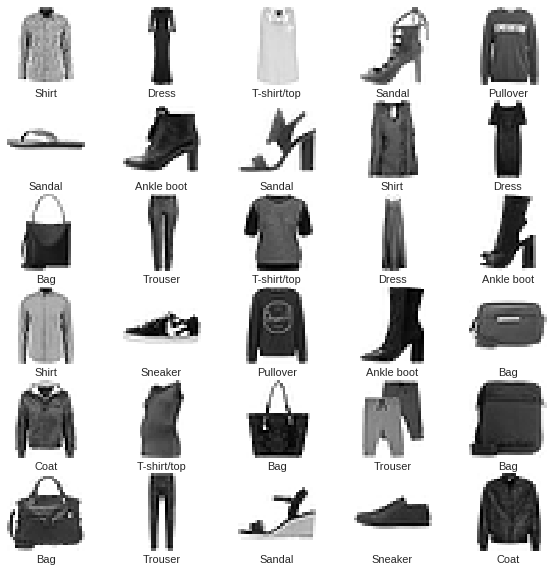

In [7]:
plt.figure(figsize=(10,10))
i=0
for(image, label) in test_dataset.take(30):
  image = image.numpy().reshape((28,28))
  plt.subplot(6,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

**Step 8**

In order to build our Neural Network model for training we will first have to flatten each image from a 28x28 single channel matrix into a flat vector (single simention array). 

Then we will pass this data through a series of Dense layers, each with 128 Neurons.

The Relu function will ensure that any value below 0 will be set to 0 so we don't get negative numbers.

Finally the Softmax function will help to categorise each of the results into 1 of 10 possible categories (which is why there are 10 neurons on the final output layer)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28,1]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

**Step 9**

We will compile the model that we just defined

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

**Step 10**

Now we can train the model using the training dataset and test it with the test dataset. We will split the images up into batches of 32 in order to make the process more discreet (in steps rather than trying to do all 60,000 at once!)

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=7, steps_per_epoch=math.ceil(num_test_examples/32))
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print("Accuracy on test dataset: {}", test_accuracy)

**Step 11**

We can use the shape property to check that the model actually does take 32 examples and outputs to 10 different catagories:

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
  
predictions.shape

Now let's see how confident the model is at prediction if the first image in the set (image 0) is one of our 10 clothing types

In [0]:
predictions[0]

We can use the argmax function of NumPy to return the idex of the highest (most confident) category

In [0]:
np.argmax(predictions[0])

And we can manually compare this value to the actual category of the first item of the set

In [0]:
test_labels[0]

Hopefully they are the same number!

**Step 12**

We can now plot the first image and a graph of the confidence to see these results

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)


**Step 13**

Fianlly let's plot the first 25 images and their confidence values for each and see if the algorithm has accurately predicted what they are!

In [0]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

**Exercises**

Try to improve the fit of the model by changing 
* the number of layers in the model
* the number of neurons in each layer
* the number of epochs that the model trains for


How does this change the accuracy of the results?

Where to next? To improve the accuarcy of the model further we will need to learn all about [Convolutional Neural Networks or CNNs!](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)